# Recommender Systems 2018/19

### Practice 3 - Content Based recommenders


### Load the data you saw last time:

In [1]:
from urllib.request import urlretrieve
import zipfile

# skip the download
#urlretrieve ("http://files.grouplens.org/datasets/movielens/ml-10m.zip", "movielens_10m.zip")
dataFile = zipfile.ZipFile("movielens_10m.zip")
URM_path = dataFile.extract("ml-10M100K/ratings.dat")
URM_file = open(URM_path, 'r')


def rowSplit (rowString):
    
    split = rowString.split("::")
    split[3] = split[3].replace("\n","")
    
    split[0] = int(split[0])
    split[1] = int(split[1])
    split[2] = float(split[2])
    split[3] = int(split[3])
    
    result = tuple(split)
    
    return result


URM_file.seek(0)
URM_tuples = []

for line in URM_file:
   URM_tuples.append(rowSplit (line))

userList, itemList, ratingList, timestampList = zip(*URM_tuples)

userList = list(userList)
itemList = list(itemList)
ratingList = list(ratingList)
timestampList = list(timestampList)

import scipy.sparse as sps

URM_all = sps.coo_matrix((ratingList, (userList, itemList)))
URM_all = URM_all.tocsr()

URM_all

FileNotFoundError: [Errno 2] No such file or directory: 'movielens_10m.zip'

## And now load the content informations in the same way:
## In this case we are using tags

In [2]:
ICM_path = dataFile.extract("ml-10M100K/tags.dat")
ICM_file = open(ICM_path, 'r')

def rowSplit (rowString):
    split = rowString.split("::")
    split[3] = split[3].replace("\n","")
    
    split[0] = int(split[0])
    split[1] = int(split[1])
    split[2] = str(split[2]) # tag is a string, not a float like the rating
    split[3] = int(split[3])
    
    result = tuple(split)
    
    return result

ICM_file.seek(0)
ICM_tuples = []

for line in ICM_file:
    ICM_tuples.append(rowSplit(line))
    
userList_icm, itemList_icm, tagList_icm, timestampList_icm = zip(*ICM_tuples)

userList_icm = list(userList_icm)
itemList_icm = list(itemList_icm)
tagList_icm = list(tagList_icm)
timestampList_icm = list(timestampList_icm)

userList_unique = list(set(userList_icm))
itemList_unique = list(set(itemList_icm))
tagList_unique = list(set(tagList_icm))

numUsers = len(userList_unique)
numItems = len(itemList_unique)
numTags = len(tagList_unique)


print ("Number of items\t {}, Number of users\t {}".format(numItems, numUsers))
print ("Number of tags\t {}, Number of item-tag tuples {}".format(numTags, len(tagList_icm)))

print("\nData example:")
print(userList_icm[0:10])
print(itemList_icm[0:10])
print(tagList_icm[0:10])

Number of items	 7601, Number of users	 4009
Number of tags	 16529, Number of item-tag tuples 95580

Data example:
[15, 20, 20, 20, 20, 20, 20, 20, 20, 20]
[4973, 1747, 1747, 2424, 2424, 2424, 2947, 2947, 3033, 3033]
['excellent!', 'politics', 'satire', 'chick flick 212', 'hanks', 'ryan', 'action', 'bond', 'spoof', 'star wars']


### The numbers of items and users in the ICM matrix is different from what we saw in the URM, why?

### The tags are string, we should traslate them into numbers so we can use them as indices in the ICM

In [3]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(tagList_icm)

tagList_icm = le.transform(tagList_icm)

print(tagList_icm[0:10])

[ 9814 13375 14131  8515 10769 14070  7015  8071 14829 14900]


# We can now build the ICM

In [4]:
import numpy as np
ones = np.ones(len(tagList_icm))
ICM_all = sps.coo_matrix((ones, (itemList_icm, tagList_icm)))
ICM_all = ICM_all.tocsr()

ICM_all

<65131x16529 sparse matrix of type '<class 'numpy.float64'>'
	with 71155 stored elements in Compressed Sparse Row format>

### Ouch, we need to add three empty items (why?):

In [5]:
missing_items = np.zeros((3, numTags))
missing_items = sps.csr_matrix(missing_items)
ICM_all = sps.vstack((ICM_all, missing_items))
ICM_all

<65134x16529 sparse matrix of type '<class 'numpy.float64'>'
	with 71155 stored elements in Compressed Sparse Row format>

# Let's take a look at the ICM

In [6]:
features_per_item = (ICM_all > 0).sum(axis=1)
items_per_feature = (ICM_all > 0).sum(axis=0)

print(features_per_item.shape)
print(items_per_feature.shape)

(65134, 1)
(1, 16529)


In [7]:
features_per_item = np.array(features_per_item).squeeze()
items_per_feature = np.array(items_per_feature).squeeze()

print(features_per_item.shape)
print(items_per_feature.shape)

(65134,)
(16529,)


In [8]:
features_per_item = np.sort(features_per_item)
items_per_feature = np.sort(items_per_feature)

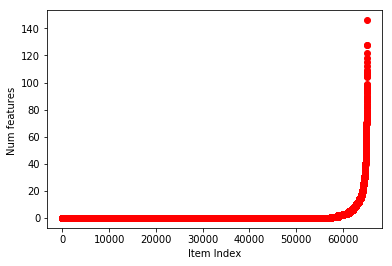

In [9]:
import matplotlib.pyplot as pyplot
%matplotlib inline  

pyplot.plot(features_per_item, 'ro')
pyplot.ylabel('Num features ')
pyplot.xlabel('Item Index')
pyplot.show()

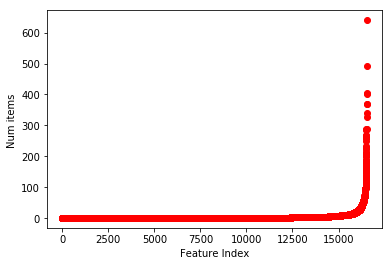

In [10]:
pyplot.plot(items_per_feature, 'ro')
pyplot.ylabel('Num items ')
pyplot.xlabel('Feature Index')
pyplot.show()

# We can now build the recommender algorithm, but first we need the train/test split and the evaluation function:

In [11]:
from data_splitter import train_test_holdout


URM_train, URM_test = train_test_holdout(URM_all, train_perc = 0.8)


from evaluation_function import evaluate_algorithm
from Compute_Similarity_Python import Compute_Similarity_Python


In [32]:
class ItemCBFKNNRecommender(object):
    
    def __init__(self, URM, ICM):
        self.URM = URM
        self.ICM = ICM
        
            
    def fit(self, topK=50, shrink=100, normalize = True, similarity = "cosine"):
        
        similarity_object = Compute_Similarity_Python(self.ICM.T, shrink=shrink, 
                                                  topK=topK, normalize=normalize, 
                                                  similarity = similarity)
        
        self.W_sparse = similarity_object.compute_similarity()

        
    def recommend(self, user_id, at=None, exclude_seen=True):
        # compute the scores using the dot product
        user_profile = self.URM[user_id]
        scores = user_profile.dot(self.W_sparse).toarray().ravel()

        if exclude_seen:
            scores = self.filter_seen(user_id, scores)

        # rank items
        ranking = scores.argsort()[::-1]
            
        return ranking[:at]
    
    
    def filter_seen(self, user_id, scores):

        start_pos = self.URM.indptr[user_id]
        end_pos = self.URM.indptr[user_id+1]

        user_profile = self.URM.indices[start_pos:end_pos]
        
        scores[user_profile] = -np.inf

        return scores

### We need to define Cosine similarity... Let's look at the attached source code

## Test our CBF recommender:

In [16]:
recommender = ItemCBFKNNRecommender(URM_train, ICM_all)
recommender.fit(shrink=0.0, topK=50)

Similarity column 36900 ( 57 % ), 1227.68 column/sec, elapsed time 0.50 min
Similarity column 65100 ( 100 % ), 1224.83 column/sec, elapsed time 0.89 min


In [18]:
for user_id in userList_unique[0:10]:
    print(recommender.recommend(user_id, at=5))

[8636  153 6333  592 1377]
[1591 8636  153 6333  592]
[65133 21706 21719 21718 21717]
[1210 1196    1 8961 2355]
[2043 1026 5651 8525 2566]
[65133 21706 21719 21718 21717]
[65133 21706 21719 21718 21717]
[   1 1210 1196 3114 4526]
[53322  4993  1270  5952  1240]
[65133 21706 21719 21718 21717]


#### Let's talk about speed

#### Time to compute recommendations for a fixed group of users

In [37]:
import time

n_users_to_test = 1000

start_time = time.time()

for user_id in range(n_users_to_test):
    recommender.recommend(user_id, at=5)
    
end_time = time.time()

print("Reasonable implementation speed is {:.2f} usr/sec".format(n_users_to_test/(end_time-start_time)))


Reasonable implementation speed is 456.80 usr/sec


### Let's add a common mistake.... a CSC URM

In [38]:
URM_train_csc = URM_train.tocsc()

recommender = ItemCBFKNNRecommender(URM_train_csc, ICM_all)
recommender.fit(shrink=0.0, topK=50)

Similarity column 39900 ( 61 % ), 1329.17 column/sec, elapsed time 0.50 min
Similarity column 65100 ( 100 % ), 1337.15 column/sec, elapsed time 0.81 min


In [39]:
import time

n_users_to_test = 1000

start_time = time.time()

for user_id in range(n_users_to_test):
    recommender.recommend(user_id, at=5)
    
end_time = time.time()

print("Wrong implementation speed is {:.2f} usr/sec".format(n_users_to_test/(end_time-start_time)))


Wrong implementation speed is 47.04 usr/sec


## Parameter tuning

#### Once we have built our model we can play with its parameters
* Number of neighbors
* Shrinkage
* Similarity type

#### Number of neighbors

In [20]:
x_tick = [10, 50, 100, 200, 500]
MAP_per_k = []

for topK in x_tick:
    
    recommender.fit(shrink=0.0, topK=topK)
    
    result_dict = evaluate_algorithm(URM_test, recommender)
    MAP_per_k.append(result_dict["MAP"])

Similarity column 37400 ( 57 % ), 1246.30 column/sec, elapsed time 0.50 min
Similarity column 65100 ( 100 % ), 1215.41 column/sec, elapsed time 0.89 min
Evaluated user 0 of 71568
Evaluated user 10000 of 71568
Evaluated user 20000 of 71568
Evaluated user 30000 of 71568
Evaluated user 40000 of 71568
Evaluated user 50000 of 71568
Evaluated user 60000 of 71568
Evaluated user 70000 of 71568
Recommender performance is: Precision = 0.1643, Recall = 0.0156, MAP = 0.1178
Similarity column 38900 ( 60 % ), 1294.82 column/sec, elapsed time 0.50 min
Similarity column 65100 ( 100 % ), 1289.29 column/sec, elapsed time 0.84 min
Evaluated user 0 of 71568
Evaluated user 10000 of 71568
Evaluated user 20000 of 71568
Evaluated user 30000 of 71568
Evaluated user 40000 of 71568
Evaluated user 50000 of 71568
Evaluated user 60000 of 71568
Evaluated user 70000 of 71568
Recommender performance is: Precision = 0.1480, Recall = 0.0139, MAP = 0.1106
Similarity column 37600 ( 58 % ), 1251.38 column/sec, elapsed time

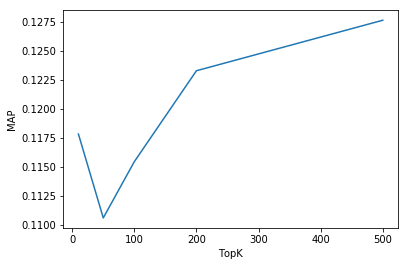

In [23]:
pyplot.plot(x_tick, MAP_per_k)
pyplot.ylabel('MAP')
pyplot.xlabel('TopK')
pyplot.show()

#### On this dataset the number of neighbors does not have a great impact on MAP. Higher values of TopK might work even better

#### Different datasets will behave in different ways.

### Shrinkage

In [24]:
x_tick = [0, 10, 50, 100, 200, 500]
MAP_per_shrinkage = []

for shrink in x_tick:
    
    recommender.fit(shrink=shrink, topK=100)
    
    result_dict = evaluate_algorithm(URM_test, recommender)
    MAP_per_shrinkage.append(result_dict["MAP"])

Similarity column 38800 ( 60 % ), 1291.88 column/sec, elapsed time 0.50 min
Similarity column 65100 ( 100 % ), 1281.75 column/sec, elapsed time 0.85 min
Evaluated user 0 of 71568
Evaluated user 10000 of 71568
Evaluated user 20000 of 71568
Evaluated user 30000 of 71568
Evaluated user 40000 of 71568
Evaluated user 50000 of 71568
Evaluated user 60000 of 71568
Evaluated user 70000 of 71568
Recommender performance is: Precision = 0.1552, Recall = 0.0147, MAP = 0.1155
Similarity column 39500 ( 61 % ), 1315.45 column/sec, elapsed time 0.50 min
Similarity column 65100 ( 100 % ), 1335.86 column/sec, elapsed time 0.81 min
Evaluated user 0 of 71568
Evaluated user 10000 of 71568
Evaluated user 20000 of 71568
Evaluated user 30000 of 71568
Evaluated user 40000 of 71568
Evaluated user 50000 of 71568
Evaluated user 60000 of 71568
Evaluated user 70000 of 71568
Recommender performance is: Precision = 0.2182, Recall = 0.0205, MAP = 0.1683
Similarity column 42200 ( 65 % ), 1405.04 column/sec, elapsed time

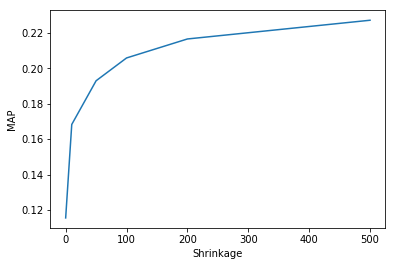

In [25]:
pyplot.plot(x_tick, MAP_per_shrinkage)
pyplot.ylabel('MAP')
pyplot.xlabel('Shrinkage')
pyplot.show()

#### The shrinkage value (i.e. support) have a much stronger impact. Combine a parameter search with the two to ensure maximum recommendation quality

## Be careful, overfitting!

#### While a thorough parameter tuning might result in significantly higher MAP on your validation split, it could have only marginally better or even worse MAP on the test set

# Feature weighting

# IDF

In [40]:
num_tot_items = ICM_all.shape[0]

# let's count how many items have a certain feature
items_per_feature = (ICM_all > 0).sum(axis=0)

IDF = np.array(np.log(num_tot_items / items_per_feature))[0]

print(ICM_all.shape)
print(IDF.shape)

(65134, 16529)
(16529,)


In [42]:
ICM_idf = ICM_all.copy()
# compute the number of non-zeros in each col
# NOTE: this works only if X is instance of sparse.csc_matrix
col_nnz = np.diff(sps.csc_matrix(ICM_idf).indptr)
print(col_nnz.shape)
print(ICM_idf.shape)
print(IDF.shape)
# then normalize the values in each col
ICM_idf.data *= np.repeat(IDF, col_nnz)

(16529,)
(65134, 16529)
(16529,)


In [43]:
recommender_idf = ItemCBFKNNRecommender(URM_train, ICM_idf)
recommender_idf.fit(shrink=0.0, topK=50)

evaluate_algorithm(URM_test, recommender_idf)

Similarity column 41000 ( 63 % ), 1364.41 column/sec, elapsed time 0.50 min
Similarity column 65100 ( 100 % ), 1354.08 column/sec, elapsed time 0.80 min
Evaluated user 0 of 71568
Evaluated user 10000 of 71568
Evaluated user 20000 of 71568
Evaluated user 30000 of 71568
Evaluated user 40000 of 71568
Evaluated user 50000 of 71568
Evaluated user 60000 of 71568
Evaluated user 70000 of 71568
Recommender performance is: Precision = 0.1509, Recall = 0.0141, MAP = 0.1124


{'precision': 0.15085720827728408,
 'recall': 0.01409744376994868,
 'MAP': 0.11240280679660732}

#### There is  a small gain over the non-weighted ICM. Try other feature weighting methods like BM25...

# Unnormalized similarity matrix

In [44]:

recommender_dot = ItemCBFKNNRecommender(URM_train, ICM_all)
recommender_dot.W_sparse = ICM_all * ICM_all.T

evaluate_algorithm(URM_test, recommender_dot)

Evaluated user 0 of 71568
Evaluated user 10000 of 71568
Evaluated user 20000 of 71568
Evaluated user 30000 of 71568
Evaluated user 40000 of 71568
Evaluated user 50000 of 71568
Evaluated user 60000 of 71568
Evaluated user 70000 of 71568
Recommender performance is: Precision = 0.3009, Recall = 0.0284, MAP = 0.2456


{'precision': 0.300881536392058,
 'recall': 0.028442700591768077,
 'MAP': 0.2455657598481565}